In [124]:
import pandas as pd
import numpy as np

# Code here
# colnames = ["age","job","marital","education", "default", "balance", "housing", "loan", "contact","day","month","duration","campaign","pdays","previous","poutcome","y"]
df = pd.read_csv("./bank-additional/bank-additional-full.csv", sep=';')

# Create a new data set with y transfored to binary data

def transform(string):
    if string=="yes":
        return 1
    else:
        return 0

y_trans = df['y'].apply(transform)
new_df = df
new_df['y'] = y_trans
new_df.head(5)

len(df.columns)

21

### Preprocessing 
Now do the proprocessing first

In [126]:
# examine all variables that are object, store them in a list
obj_col_list = []
for column in new_df.columns:
    if new_df.dtypes[column] == 'object':
        print(new_df.groupby([column]).size())
        obj_col_list.append(column)

job
admin.           10422
blue-collar       9254
entrepreneur      1456
housemaid         1060
management        2924
retired           1720
self-employed     1421
services          3969
student            875
technician        6743
unemployed        1014
unknown            330
dtype: int64
marital
divorced     4612
married     24928
single      11568
unknown        80
dtype: int64
education
basic.4y                4176
basic.6y                2292
basic.9y                6045
high.school             9515
illiterate                18
professional.course     5243
university.degree      12168
unknown                 1731
dtype: int64
default
no         32588
unknown     8597
yes            3
dtype: int64
housing
no         18622
unknown      990
yes        21576
dtype: int64
loan
no         33950
unknown      990
yes         6248
dtype: int64
contact
cellular     26144
telephone    15044
dtype: int64
month
apr     2632
aug     6178
dec      182
jul     7174
jun     5318
mar      546
may

### Preprocessing

1. One-hot encoding of categorical variables

In [127]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# a function to do one-hot-encoding for categorical variables
# input is an nparray of categorical values, ncol = 1, nrow = len(dataset)
# output is a pd dataframe of one-hot vectors. ncol = number of categoreis, nrow = len(dataset)
def one_hot_encoding(values):
    # first do the one-hot encoding. return a np array of vectors.
    ori_index = values.index
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values) #  
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    # then transform the vector into pd dataframe with proper column names
    col_names = [values.name + '_' + x for x in label_encoder.classes_.tolist()]
    one_hot_encoding_df = pd.DataFrame(onehot_encoded.tolist(), columns = col_names, index = ori_index)

    return one_hot_encoding_df

In [128]:
def integer_encoding(values):
    # first do the one-hot encoding. return a np array of vectors.
    ori_index = values.index
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values) #  
    return integer_encoded

In [129]:
obj_col_list

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [132]:
# This part does the transformation of one-hot vectors
num_col_list = list(set(new_df.columns).difference(obj_col_list)) # the list of columns that are of numerical values
num_col_list
new_df_num = new_df[num_col_list]
new_df_num.shape

(41188, 11)

In [133]:
for col in obj_col_list:
    df_mini = one_hot_encoding(new_df[col])
    new_df_num = pd.concat([new_df_num, df_mini], axis=1, join_axes=[new_df_num.index])

In [134]:
new_df_num.shape

(41188, 64)

##### Split data here

In [135]:
## Here we split the data
train_df = new_df_num.sample(frac = 0.8, replace = False) 
test_df = new_df_num[~df.index.isin(train_df.index)]
# train_df.head(5)

In [136]:
train_df.shape

(32950, 64)

In [137]:
test_df.shape

(8238, 64)

Prepare for fitting a model.

In [138]:
# fit a classification tree
train_features = train_df_num.drop(labels = 'y', axis = 1)
train_target = train_df_num['y']
test_features = test_df_num.drop(labels = 'y', axis = 1)
test_target = test_df_num['y']

### Logistic regression
The binary classification goal is to predict if the client will subscribe a bank term deposit (variable y).

### Decision Tree

In [57]:
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

# defines a classification tree
def testTrees(X_train,y_train,X_test,y_test,dep,leaf,auc):
    clf = DecisionTreeClassifier(criterion='entropy',min_samples_leaf=leaf,max_depth=dep)
    clf = clf.fit(X_train,y_train)
    if (auc==0):
        cm = confusion_matrix(clf.predict(X_test),y_test)
        return (cm[0][0]+cm[1][1])/float(sum(cm))
    else:
        return roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])

In [58]:
import matplotlib.pyplot as plt

lab='y_buy'

depths=[4,5,10,20]
leaves=np.arange(1,101)

#Run all of the options
run=1
if (run==1):
    #Initialize dictionary of results
    res=dict()
    for d in depths:
        res[d]=list()

    #Now train and get results for each option
    for d in depths:
        for l in leaves:
            res[d].append(testTrees(train_features,train_target,test_features,test_target, d, l, 1))


#Now plot            
fig = plt.figure()
ax=fig.add_subplot(111)
plt.plot(leaves,res[depths[0]],'b-',label='Depth={}'.format(depths[0]))
plt.plot(leaves,res[depths[1]],'r-',label='Depth={}'.format(depths[1]))
plt.plot(leaves,res[depths[2]],'y-',label='Depth={}'.format(depths[2]))
plt.plot(leaves,res[depths[3]],'g-',label='Depth={}'.format(depths[3]))
plt.legend(loc=4)
ax.set_xlabel('Min Leaf Size')
ax.set_ylabel('Test Set AUC')
plt.title('Holdout AUC by Hyperparameters')

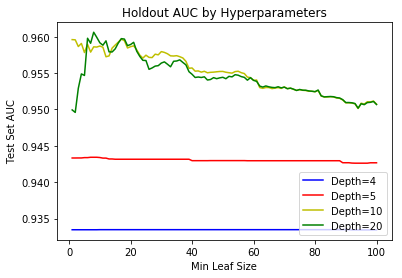

In [59]:
plt.show()

### Now it's random forest

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
# import course_utils as bd
# imp.reload(bd)

In [113]:
# We'll build a RF and compare to a DT
clf_def = DecisionTreeClassifier(criterion='entropy', min_samples_leaf = 20)
clf_def = clf_def.fit(train_features, train_target)
# dt_pred = clf_def.predict_proba(test_features)
dt_pred = clf_def.predict(test_features)

rf_def = RandomForestClassifier(criterion='entropy', n_estimators=100)
rf_def = rf_def.fit(train_features, train_target)
# rf_pred = rf_def.predict_proba(test_features)
rf_pred = rf_def.predict(test_features)

In [102]:
# A function to plot AUC, from course Git

def plotAUC(truth, pred, lab):
    fpr, tpr, thresholds = roc_curve(truth, pred)
    roc_auc = auc(fpr, tpr)
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color=c, label= lab+' (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")

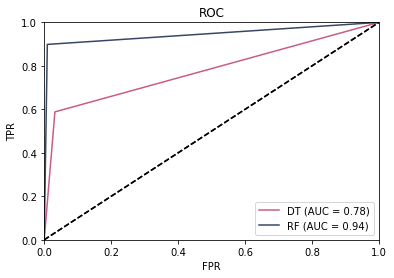

In [114]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

plotAUC(test_target, dt_pred, 'DT')
plotAUC(test_target, rf_pred, 'RF')
plt.show()